resource used: https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=qoW2Z7P70LNQ 

In [169]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.7.1


data used: Zachary's karate club network
- describes a social network of 34 members of a karete club and documents links between members who interacted outside the club
- interested in detecting communities that come from member intraction (links?)

- exploring pytorch geometric (PyG) for implementation of GNNs

In [170]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


- dataset holds one graph
- each node has a 34-dimensional feature vector (uniquely describes the members of the karate club)
- each graph has 4 classes, which represents the community each members belongs to

In [171]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges/data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_directed()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: False


- each graph in PyG is represented by a single Data object -> holds all information in its graph representation
- Data object holds 4 attributes  
    (1) edge index: graph connectivity (source node, destination node) -> this is in coordinate (COO) format  
    (2) node features (x): each of the 34 nodes is assigned a 34-dim feature vector  
    (3) node labels (y):  each node is assigned tot exactly one class  
    (4) train mask: describes which nodes already know their community assignments  
- we only know the ground truth for 4 nodes (classes) and our task is to figure out the community assignment for the other nodes (classes)
- PyG does not distinguish between directed and undirected graphs. It treats undirected graphs as directed graphs by reversing the edges for every entry in edge_index.

In [172]:
# from IPython.display import Javascript  # Restrict height of output cell.
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

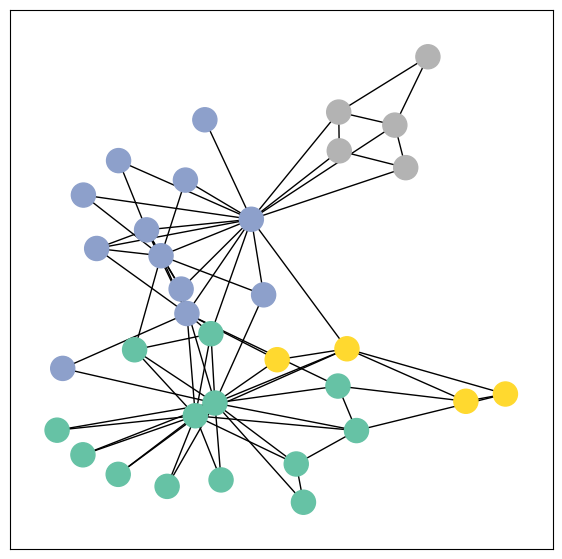

In [173]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

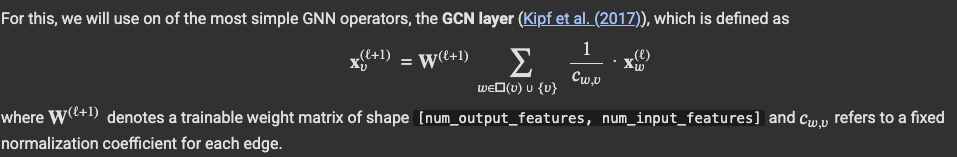

In [174]:
from IPython import display
display.Image("/var/folders/x5/nk2s0y9j023dsj349jm6v7fh0000gn/T/TemporaryItems/NSIRD_screencaptureui_d8BTfe/Screenshot 2025-06-20 at 10.34.27 AM.png")

In [175]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()

        out = self.classifier(h)

        return out, h
model = GCN()
print(model)


GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


steps:  
- initialize all building blocks in __init__
- define computational flow of the network in forward
- define and stack three GCN layers (aggregrating to 3-hop neighborhood information around each node, all nodes are up to 3 "hops" away)
- "hops" refer to how far you are from the target node in terms of graph structure (1-hop = directly connected, 2-hop = neighbors of neighbors, etc)
- the GCNConv layers reduce the node feature dimensionality to 2 (34- > 4 -> 4 -> 2)
- each GCNConv layer is enhanced by a tanh non-linearity
- after that, a linear transformation is applied (out = self.classifier(h) -> torch.nn.Linear) to act as a classifier to map our nodes to 1 out of 4 classes
- return out = output of the final classifier and h = final node embeddings produced by GNN
- final node embeddings are the vector representations of the nodes that the GCN has processed

Embedding shape: [34, 2]


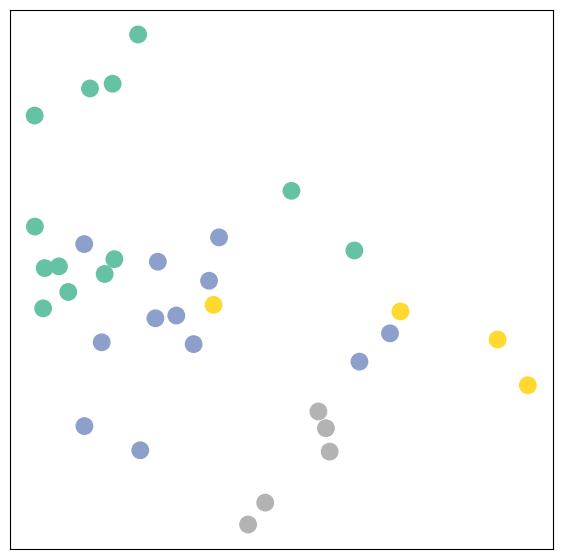

In [176]:
#looking at the node embeedings 
model = GCN()
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
visualize_embedding(h, color = data.y)

although we have not added any weights, the GCN has already sorted the nodes into a rough outline of the communities. this shows that GNNs introduce a strong inductive bias, which leads to embeddings for nodes that are close to each other in the input graph

##training on the karate club network
- since the model is differentiable and parameterized, we can add lables, train the model, and obserbe how the embeddings react
- we can train against one node per class, but are allowed to make use of the complete input graph data
- define a loss criterion (CrossEntropyLoss) and initilize a stochastic gradient optimizer (Adam)
= after that, perform multiple rounds of optimization where each round is a forward and backward pass to compute the gradients of our model params with respect to the loss derived from the forward pass

- only use the training nodes for computing the loss
- this implemented by filtering the output of the classifier out and ground truth labels data.y to only contain nodes in the train_mask

In [ ]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index) #perform a single forward pass
    pred = torch.argmax(out, dim=1) #convert out (logits) to class labels

    #get accuracy
    num_examples = data.train_mask.sum()
    correct_pred = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    accuracy = correct_pred.float()/num_examples *100
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) #compute the loss solely based on the training nodes

    #backwards and update
    loss.backward()
    optimizer.step() #update params
    return loss, h, accuracy

total_loss = []
epochs = []
accs = []

for epoch in range(100):
    loss, h, acc = train(data)
    accs.append(acc)
    total_loss.append(loss.detach().numpy())
    epochs.append(epoch)
    # if epoch % 10 == 0:
        # visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        # time.sleep(0.3)

Text(0, 0.5, 'accuracy')

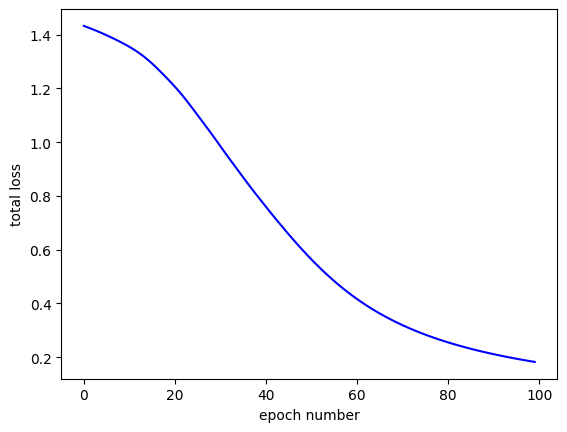

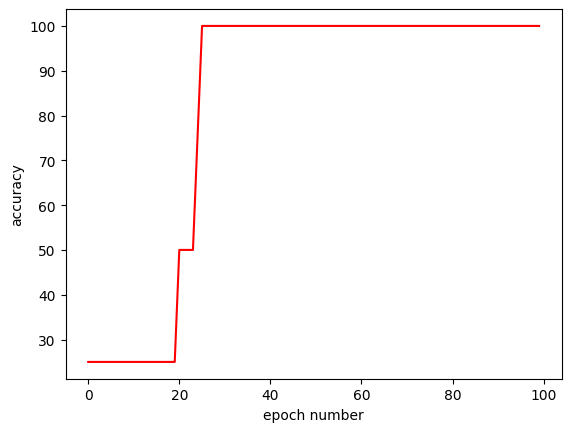

In [178]:
fig = plt.figure()
plt.plot(epochs, total_loss, color="blue")
plt.xlabel('epoch number')
plt.ylabel('total loss')

fig = plt.figure()
plt.plot(epochs, accs, color="red")
plt.xlabel('epoch number')
plt.ylabel('accuracy')